What's new in this version?

 - Updated weather data to ensure that forecast and historical data share the same features
 - Changing the threshold for severely delayed flights to even-out the distribution
 - Hyperparameter changes
 - Final merged dataframe is now cached with the notebook version name

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path

%matplotlib notebook

In [2]:
csv_glob = list(Path('../data/').glob('*_weather.csv'))

CACHE_PATH = '../data/FINAL_DATA_v2.csv'
DO_CACHE = True

mapper = {x.name.split('_')[0]: x for x in csv_glob}
print(mapper)

{'EWR': PosixPath('../data/EWR_weather.csv'), 'DEN': PosixPath('../data/DEN_weather.csv'), 'IAD': PosixPath('../data/IAD_weather.csv'), 'ORD': PosixPath('../data/ORD_weather.csv'), 'SYR': PosixPath('../data/SYR_weather.csv')}


In [3]:
def preprocess_weather_df(df):
    df['time'] = pd.to_datetime(df['time'])
    df['Date'] = pd.to_datetime(df.time.apply(lambda x: x.date()))
    df['Time'] = df.time.apply(lambda x: x.time())
    df.drop(columns=['time'], inplace=True, axis='columns')
    return df


def create_label(arrival_delay):
    if arrival_delay < -10:
        return "early"
    if -10 <= arrival_delay <= 10:
        return "on_time"
    if 10 < arrival_delay <= 30:
        return "delayed"
    if arrival_delay > 30:
        return "severely_delayed"
    
    raise NotImplementedError("unknown timeframe")

    
def create_data_df():
    
    if not DO_CACHE:
        return pd.read_csv(CACHE_PATH)

    anchor_df = pd.read_csv('../data/Detailed_Statistics_Arrivals.csv')

    #drop any NaNs.
    anchor_df.dropna(inplace=True, axis='rows')

    # Remove carrier code, tail number
    # Rename Flight Number

    anchor_df['Date (MM/DD/YYYY)'] = pd.to_datetime(anchor_df['Date (MM/DD/YYYY)'])
    anchor_df.drop(columns=['Carrier Code', 'Tail Number'], axis='columns', inplace=True)
    anchor_df['Flight Number'] = anchor_df['Flight Number'].apply(lambda x: "UA " + str(int(x)))
    anchor_df['Scheduled Arrival Time'] = pd.to_datetime(anchor_df['Scheduled Arrival Time'])
    anchor_df['Arrival Time (Rounded)'] = anchor_df['Scheduled Arrival Time'].dt.round('H')
    anchor_df['Scheduled Arrival Time'] = anchor_df['Scheduled Arrival Time'].apply(lambda x: x.time())

    # Arrival time.
    anchor_df['Arrival Time (Rounded)'] = anchor_df['Arrival Time (Rounded)'].apply(lambda x: x.time())
    
    # ------------------------------
    
    airport_dfs = []
    for airport_name in anchor_df['Origin Airport'].unique():

        sub_df = anchor_df.loc[anchor_df['Origin Airport'] == airport_name, :].reset_index(
            drop=True, inplace=False
        )

        weather_df = preprocess_weather_df(pd.read_csv(mapper[airport_name]))

        merged = sub_df.merge(
            right=weather_df,
            left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
            right_on=['Date', 'Time'],
            how='inner'
        ).reset_index(drop=True, inplace=False)

        airport_dfs.append(merged)
    
    # ------------------------------
    
    df = pd.concat(airport_dfs, axis=0)
    df = df.sort_values(
        by=['Origin Airport', 'Date (MM/DD/YYYY)'], 
        axis=0, 
        inplace=False
    ).reset_index(drop=True, inplace=False)
    
    # ------------------------------
    
    # Add SYR weather.
    syr_weather = preprocess_weather_df(pd.read_csv(mapper['SYR']))
    syr_weather.columns = ['syr_' + x for x in syr_weather.columns]

    df = df.merge(
            right=syr_weather,
            left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
            right_on=['syr_Date', 'syr_Time'],
            how='inner'
        ).reset_index(drop=True, inplace=False)
    
    # ------------------------------
    
    df['arrival_status'] = df['Arrival Delay (Minutes)'].apply(lambda x: create_label(x))
    
    df.drop(
        columns=[
            'Date (MM/DD/YYYY)',
            'Scheduled Arrival Time',
            'Actual Arrival Time',
            'Scheduled Elapsed Time (Minutes)',
            'Actual Elapsed Time (Minutes)',
            'Arrival Delay (Minutes)',                 # TODO: Think about this.
            'Delay Carrier (Minutes)',
            'Delay Weather (Minutes)',
            'Delay National Aviation System (Minutes)',
            'Delay Security (Minutes)', 
            'Delay Late Aircraft Arrival (Minutes)',
            'Arrival Time (Rounded)', 
            'Date', 
            'Time',
            'syr_Date',
            'syr_Time'
        ], axis='columns', inplace=True
    )
    
    return df

In [4]:
df = create_data_df()

print(df.shape)

(2090, 39)


<IPython.core.display.Javascript object>


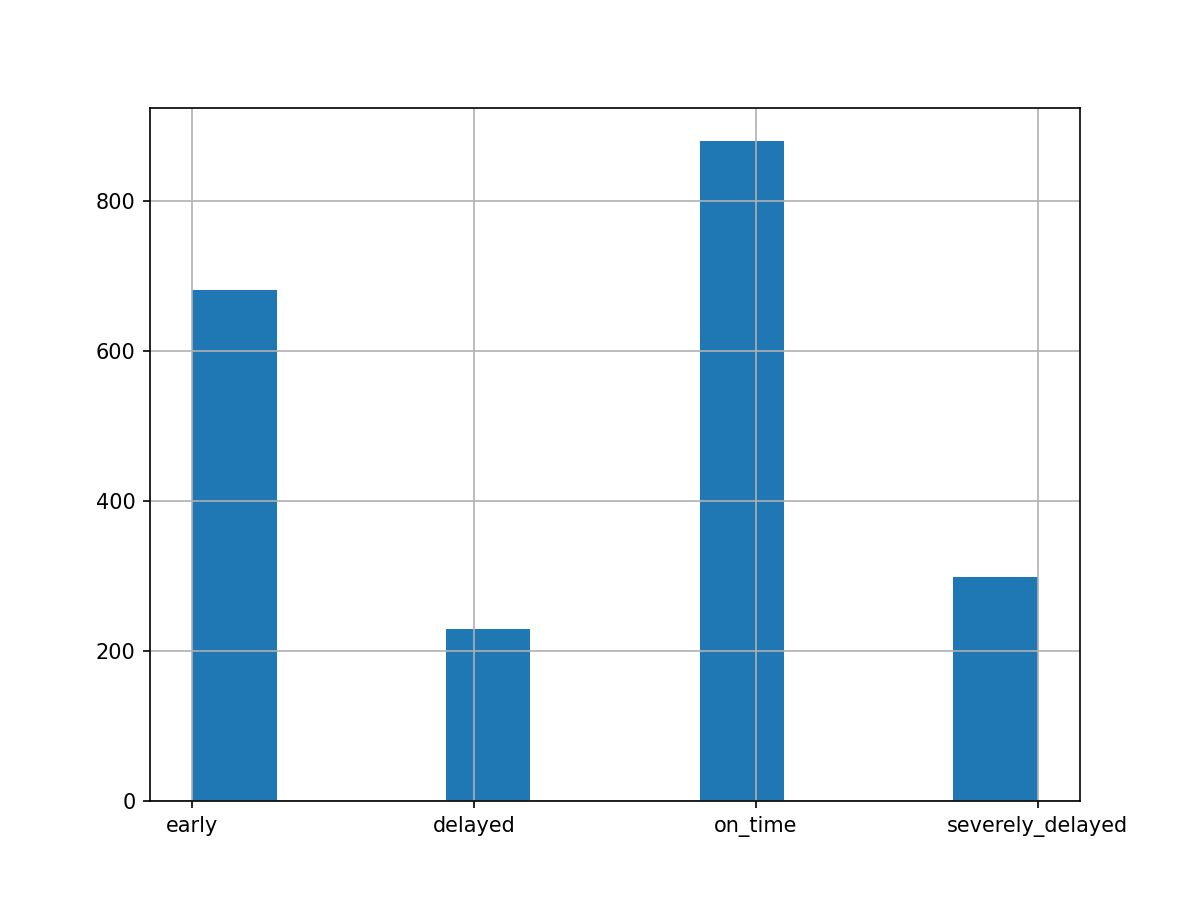

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
df['arrival_status'].hist(ax=ax)
plt.show()

### Modeling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
# OHE
flight_number_encoder = OneHotEncoder()
origin_airport_encoder = OneHotEncoder()

flight_number_ohe = flight_number_encoder.fit_transform(df[['Flight Number']].values).toarray()
airport_ohe = origin_airport_encoder.fit_transform(df[['Origin Airport']].values).toarray()

flight_number_ohe = pd.DataFrame(
    flight_number_ohe, 
    columns=flight_number_encoder.get_feature_names_out()
)

airport_ohe = pd.DataFrame(
    airport_ohe,
    columns=origin_airport_encoder.get_feature_names_out()
)

# Join
df = pd.concat([df, flight_number_ohe, airport_ohe], axis=1)

df.drop(
    columns=['Flight Number', 'Origin Airport'],
    axis='columns',
    inplace=True
)

In [8]:
df.dropna(axis='rows', inplace=True)

In [9]:
if DO_CACHE:
    df.to_csv(CACHE_PATH, index=False)

In [10]:
X = df.loc[:, ~df.columns.isin(['arrival_status'])]
Y = df.loc[:, 'arrival_status']

X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, shuffle=True, random_state=420, stratify=Y)

print(f"{X_tr.shape=}, {X_te.shape=}, {Y_tr.shape=}, {Y_te.shape=}")

X_tr.shape=(1567, 131), X_te.shape=(523, 131), Y_tr.shape=(1567,), Y_te.shape=(523,)


In [11]:
scaler = StandardScaler()
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), columns=scaler.feature_names_in_)
X_te_scaled = pd.DataFrame(scaler.transform(X_te), columns=scaler.feature_names_in_)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

max_sweeps = 10
performance = {'train': [], 'test': [], 'models': []}

model_params = {
    'n_estimators': [10, 25, 50, 100, 150, 200],
    'loss': ['log_loss'],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [2,3,4,5],
    'max_depth': [10, 30, 50, 70, 100],
    'max_features': ['sqrt', 'log2', None]
}

for ix in tqdm(range(max_sweeps)):
    params = {k: np.random.choice(model_params[k]) for k in model_params.keys()}
    model = GradientBoostingClassifier(**params).fit(X_tr_scaled, Y_tr)
    performance['train'].append(model.score(X_tr_scaled,Y_tr))
    performance['test'].append(model.score(X_te_scaled,Y_te))
    performance['models'].append(model)

100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


In [15]:
# Grab the best model.
def get_best_model(performance_dict, metric='test', return_ix=False):
    if metric not in ['train', 'test']:
        raise NotImplementedError("Unknown metric type")
    
    if metric == 'train':
        argmax = np.argmax(performance_dict['train'])
        model = performance_dict['models'][argmax]
    else:
        argmax = np.argmax(performance_dict['test'])
        model = performance_dict['models'][argmax]
        
    if not return_ix:
            return model, -1
    else:
        return model, argmax

In [16]:
best_model, ix = get_best_model(performance, metric='test', return_ix=True)

print("train R2: ", performance['train'][ix])
print("test R2: ", performance['test'][ix])

train R2:  0.9808551372048501
test R2:  0.44933078393881454


In [17]:
feature_df = pd.DataFrame(columns=['feature_name', 'importance'])
feature_df['feature_name'] = best_model.feature_names_in_
feature_df['importance'] = best_model.feature_importances_
feature_df.sort_values(by='importance', ascending=False, inplace=True, axis=0)

display(feature_df.head(15))

,feature_name,importance
5,surface_pressure,0.043635
2,dewpoint_2m,0.042001
14,winddirection_10m,0.041171
4,pressure_msl,0.037932
22,syr_pressure_msl,0.035748
31,syr_windspeed_10m,0.034384
17,vapor_pressure_deficit,0.033774
13,windspeed_10m,0.033728
0,temperature_2m,0.033608
1,relativehumidity_2m,0.033546


In [19]:
pred_df = pd.DataFrame(
    {
        'y_true': Y_te,
        'y_pred': best_model.predict(X_te)
    }
)

display(pred_df)

,y_true,y_pred
1402,early,early
291,early,early
440,early,delayed
411,on_time,severely_delayed
357,on_time,early
...,...,...
1884,severely_delayed,early
1511,early,delayed
1868,delayed,delayed
39,delayed,on_time


<IPython.core.display.Javascript object>


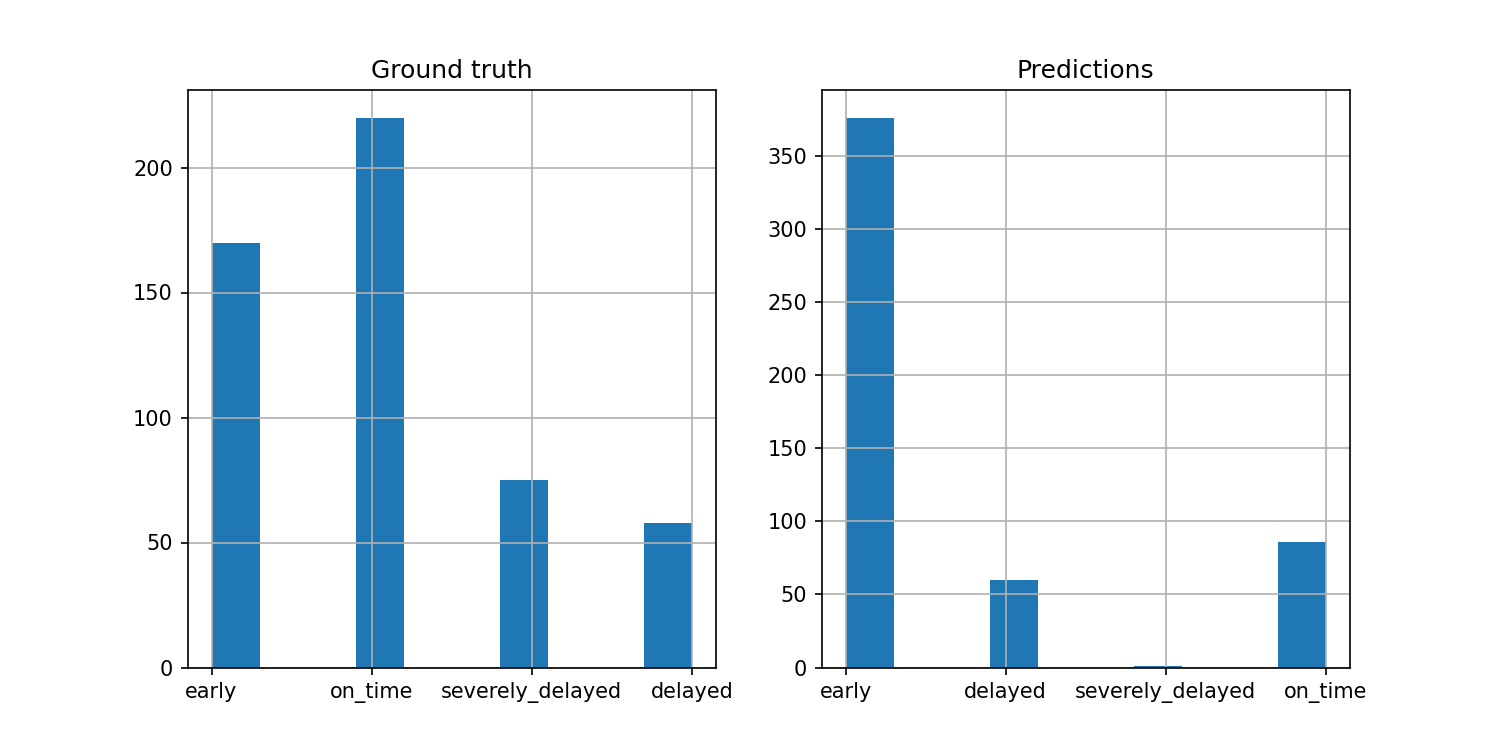

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
pred_df.y_true.hist(ax=ax[0])
pred_df.y_pred.hist(ax=ax[1])
ax[0].set_title('Ground truth')
ax[1].set_title('Predictions')
plt.show()